# Exercise 4

setting our enviornment

In [8]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_numeric_dtype
# Import models from scikit learn module:
from sklearn.cross_validation import KFold  # For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Preprocessing

reading the data:

In [9]:
df=pd.read_csv("./data/train.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


visual graphs of values:

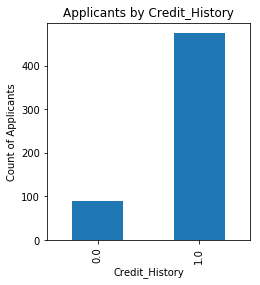

In [12]:
temp1 = df['Credit_History'].value_counts(ascending=True)
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

filling missing data. We wrote a function that itterates all the columns and fill them out with the most common value (for categorial) and the mean of column (for numerical). After looking on the train and test we found out that there are a few columns that their values are numbers but in fact are categorial. In those columns the maximum of values is 12 (for numerical there's alot more values).

In [16]:
def fillingMissing(tf):
    for column in tf:
        if (column!='LoanAmount'):
            whu=tf[column].value_counts()
            x = tf[column].value_counts().size > 12
            y = is_numeric_dtype(tf[column])
            if (x & y):
                tf[column].fillna(tf[column].mean(), inplace=True)
            else:
                max_val = tf[column].value_counts().idxmax()
                tf[column].fillna(max_val, inplace=True)
    return tf

For **LoanAmount** - we will create a Pivot table, which provides us median values for all the groups of unique values of Self_Employed and Education features. Next, we define a function, which returns the values of these cells and apply it to fill the missing values of loan amount:

In [17]:
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
table

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


Define function to return value of this pivot_table:

In [18]:
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]

and now replace the missing values in LoanAmount:

In [19]:
df = fillingMissing(df)
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

convert all our categorical variables into numeric by encoding the categories:

In [20]:
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i].astype(str))
df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
dtype: object

Treating extreme values: since the extreme values are practically possible, i.e. some people might apply for high value loans due to specific needs. So instead of treating them as outliers, let’s try a log transformation to nullify their effect:

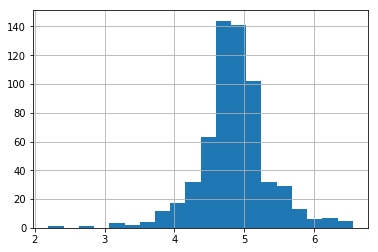

In [21]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)

One intuition can be that some applicants have lower income but strong support Co-applicants. So it might be a good idea to combine both incomes as total income and take a log transformation of the same.

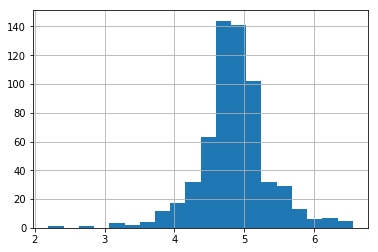

In [22]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['LoanAmount_log'].hist(bins=20) 

### Building a Predictive Model in Python

Generic function for making a classification model and accessing performance (after few tries we choose n_folds=10):

In [23]:
def classification_model(model, data, predictors, outcome):
    # Fit the model:
    model.fit(data[predictors], data[outcome])

    # Make predictions on training set:
    predictions = model.predict(data[predictors])

    # Print accuracy
    accuracy = metrics.accuracy_score(predictions, data[outcome])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))

    # Perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=10)
    error = []
    for train, test in kf:
        # Filter training data
        train_predictors = (data[predictors].iloc[train, :])

        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]

        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)

        # Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test, :], data[outcome].iloc[test]))

    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    # Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors], data[outcome])

We tried alot of various models including: Gaussian Process Classifier, Gradient Boosting Classifier, K Neighbors Classifier, SVM etc. You can see the acurricies in the image below.
We choose finally the Linear Discriminant Analysis and Gradient Boosting Classifier because they had the highest acurracies.

#### Gradient Boosting Classifier

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.
We tried multiple values for the features:
n-estimators->10,25,50.
max_depth->3,5,6.
min_samples_split->7,10,15
You can see the image with the acurricies below. We chose the parameters that maximized the accuracy.

In [24]:
outcome_var = 'Loan_Status'
predictor_var = ['TotalIncome', 'LoanAmount', 'Credit_History', 'Dependents', 'Property_Area']
model = GradientBoostingClassifier(n_estimators=10, max_depth=3, min_samples_split=15)
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 81.759%
Cross-Validation Score : 80.632%


next we fill the missing data in the test set like in the test set and changed the categorial features to be numbers.

In [27]:
testdf = pd.read_csv("./data/test.csv")
testdf = fillingMissing(testdf)
testdf['LoanAmount'].fillna(testdf[testdf['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)
testdf['TotalIncome'] = testdf['ApplicantIncome'] + testdf['CoapplicantIncome']
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
le = LabelEncoder()
for i in var_mod:
    testdf[i] = le.fit_transform(testdf[i].astype(str))

Now we predict the test set and write the predictions to the output file.

In [28]:
predictions = model.predict(testdf[predictor_var])
predictions=['Y' if pred == 1 else 'N' for pred in predictions]
tocsv = {'Loan_ID':testdf['Loan_ID'], 'Loan_Status':predictions}
dataf = pd.DataFrame(tocsv)
dataf.to_csv('GradientBoostingClassifier.csv')

#### Linear Discriminant Analysis

Linear Discriminant Analysis a classifier with a linear decision surface.
This classifier is attractive because it have closed-form solutions that can be easily computed, are inherently multiclass, have proven to work well in practice and have no hyperparameters to tune.
We choose the shrinkage='auto' and the solver='lsqr' because they maximized our accuracy.

In [30]:
outcome_var = 'Loan_Status'
model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto') 
predictor_var = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Amount_Term',
                 'ApplicantIncome','CoapplicantIncome', 'LoanAmount', 'Credit_History', 'Dependents', 'Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 81.107%
Cross-Validation Score : 80.960%


next we fill the missing data in the test set like in the test set and changed the categorial features to be numbers.

In [31]:
testdf = pd.read_csv("./data/test.csv")
testdf = fillingMissing(testdf)
testdf['LoanAmount'].fillna(testdf[testdf['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
le = LabelEncoder()
for i in var_mod:
    testdf[i] = le.fit_transform(testdf[i].astype(str))

Now we predict the test set and write the predictions to the output file.

In [32]:
predictions = model.predict(testdf[predictor_var])
predictions=['Y' if pred == 1 else 'N' for pred in predictions]
tocsv = {'Loan_ID':testdf['Loan_ID'], 'Loan_Status':predictions}
dataf = pd.DataFrame(tocsv)
dataf.to_csv('LinearDiscriminantAnalysis.csv')